In [4]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

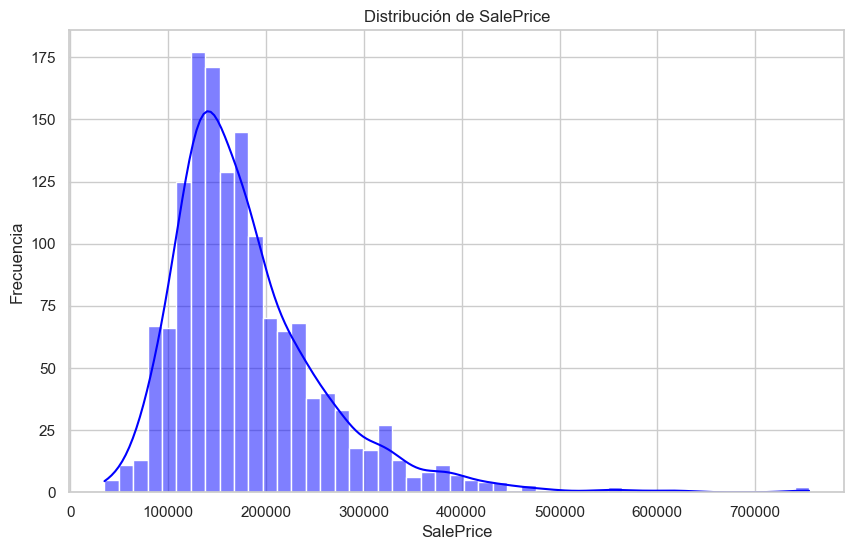

Skewness de SalePrice: 1.8828757597682129
Curtosis de SalePrice: 6.536281860064529


In [5]:
# 1. Cargar los datos
# Asegúrate de cambiar el path al archivo descargado de Kaggle
df = pd.read_csv("../Data/train.csv")

# Exploración inicial
print(df.info())
print(df.describe())
print(df.head())

# Visualizar la distribución de la variable objetivo (SalePrice)
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title("Distribución de SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frecuencia")
plt.show()

# Evaluar skewness y curtosis
print(f"Skewness de SalePrice: {df['SalePrice'].skew()}")
print(f"Curtosis de SalePrice: {df['SalePrice'].kurt()}")


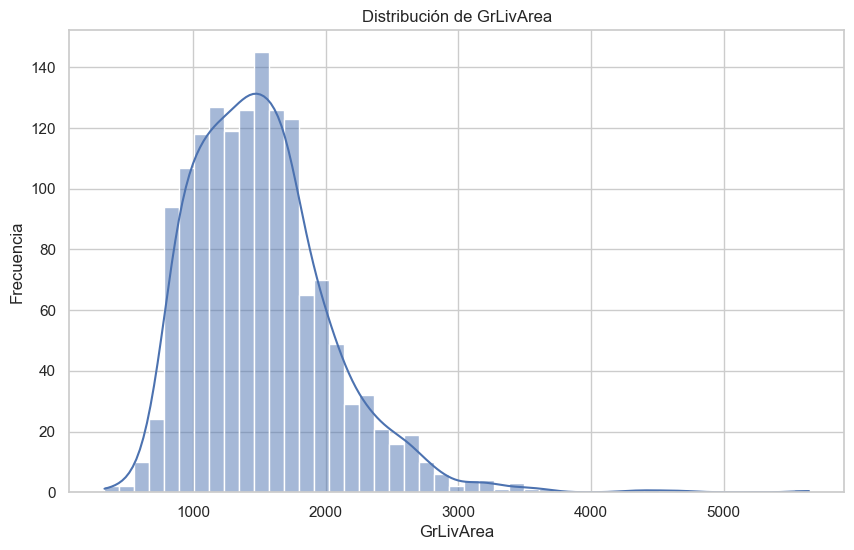

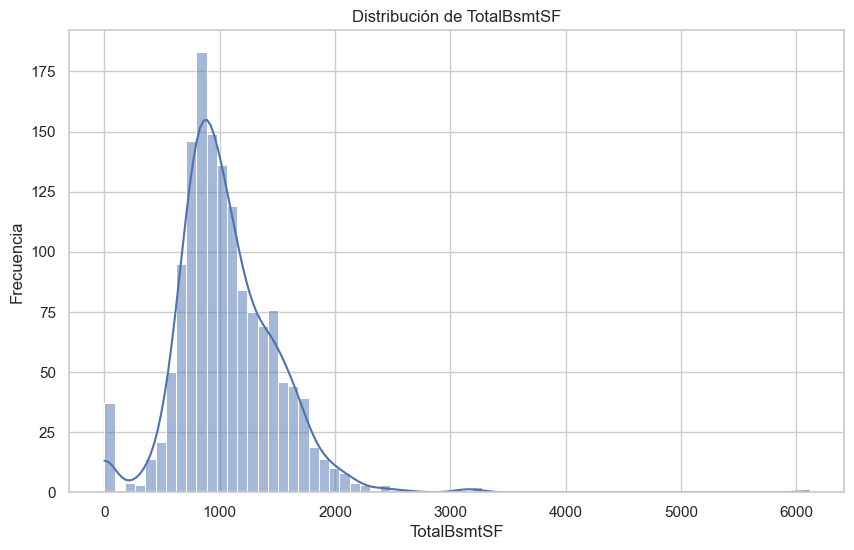

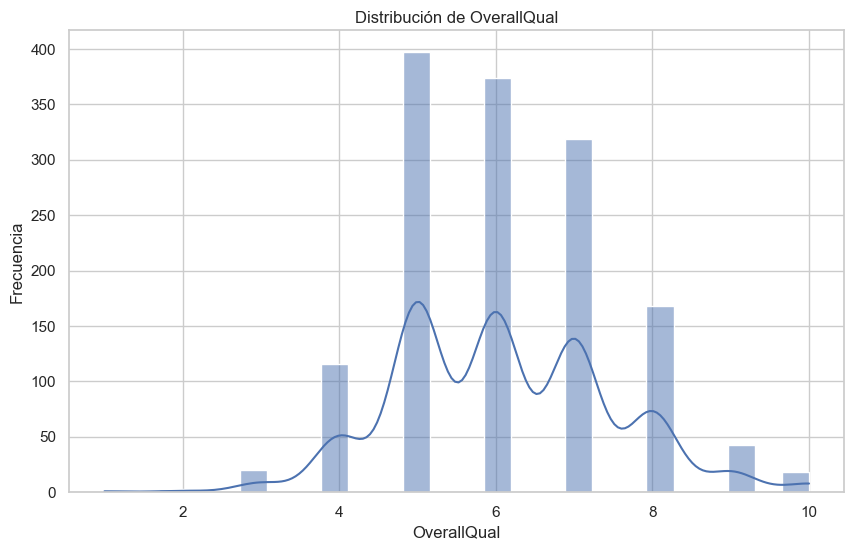

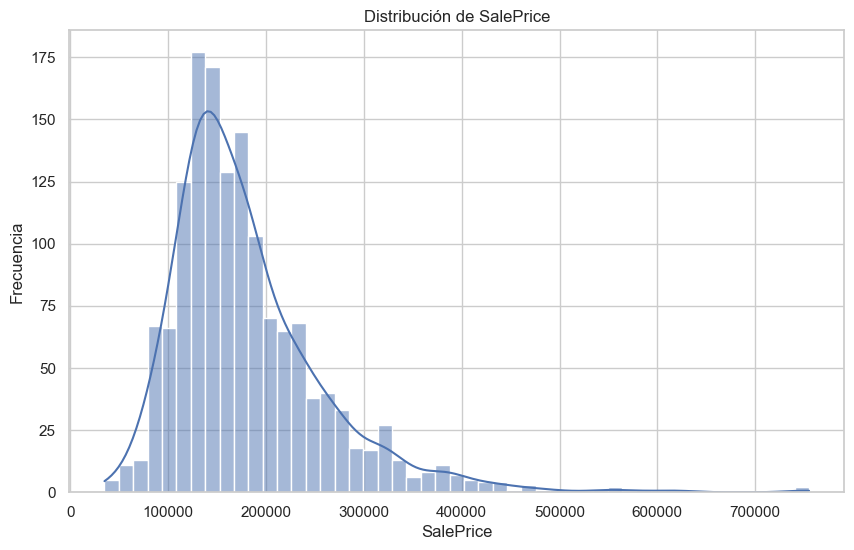

Variables con skewness:
 SalePrice      1.882876
TotalBsmtSF    1.524255
GrLivArea      1.366560
OverallQual    0.216944
dtype: float64


In [6]:
# 2. Exploración de variables numéricas clave
# Selección de variables para analizar su distribución
numerical_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'SalePrice']
for feature in numerical_features:
    sns.histplot(df[feature], kde=True)
    plt.title(f"Distribución de {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frecuencia")
    plt.show()

# Identificar skewness en variables numéricas
skewed_features = df[numerical_features].skew().sort_values(ascending=False)
print("Variables con skewness:\n", skewed_features)


In [7]:
#Puedo identificar los outliers con el rango intercuartilico (IQR)

numeric_features = df.select_dtypes(include=['number'])

skewness = numeric_features.apply(lambda x: x.skew()) #Forma de calcular las asimetrias

#Función para calcular los outliers
def calculate_outliers(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return len(x[(x < lower_bound) | (x > upper_bound)])

outliers = numeric_features.apply(calculate_outliers)

#Combino skewness y outliers en un DataFrame
analysis = pd.DataFrame({'Skewness': skewness, 'Outliers': outliers})

#Lo que haré ahora es filtrar los que son relevantes
candidates = analysis[(analysis['Skewness'].abs() > 1) | (analysis['Outliers'] > 0)]

#Imprimo esto
print('Variables candidatas para transformaciones:')
print(candidates)

Variables candidatas para transformaciones:
                Skewness  Outliers
MSSubClass      1.407657       103
LotFrontage     2.163569        88
LotArea        12.207688        69
OverallQual     0.216944         2
OverallCond     0.693067       125
YearBuilt      -0.613461         7
MasVnrArea      2.669084        96
BsmtFinSF1      1.685503         7
BsmtFinSF2      4.255261       167
BsmtUnfSF       0.920268        29
TotalBsmtSF     1.524255        61
1stFlrSF        1.376757        20
2ndFlrSF        0.813030         2
LowQualFinSF    9.011341        26
GrLivArea       1.366560        31
BsmtFullBath    0.596067         1
BsmtHalfBath    4.103403        82
BedroomAbvGr    0.211790        35
KitchenAbvGr    4.488397        68
TotRmsAbvGrd    0.676341        30
Fireplaces      0.649565         5
GarageCars     -0.342549         5
GarageArea      0.179981        21
WoodDeckSF      1.541376        32
OpenPorchSF     2.364342        77
EnclosedPorch   3.089872       208
3SsnPorch  

In [8]:
# 3. Transformaciones de variables
# Variables a transformar
log_transform_vars = [
    'MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
    'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice'
]

# Aplico la transformación logarítmica
for col in log_transform_vars:
    if col in df.columns:
        df[col] = np.log1p(df[col])  # Logaritmo natural log(x + 1), asegura que no haya problemas con 0

In [9]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


# Identificar solo las columnas numéricas
num_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Preprocesamiento para datos numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación de valores faltantes
    ('scaler', StandardScaler())  # Escalado estándar
])

# Ahora hago el preprocesamiento solo para las columnas numéricas
data_processed = numeric_transformer.fit_transform(df[num_columns])

# Generar características polinómicas
poly = PolynomialFeatures(degree=2, include_bias=False)

# Aplico PolynomialFeatures a las columnas numéricas procesadas
data_poly = poly.fit_transform(data_processed)

# Convertir a DataFrame con nombres de las nuevas características
poly_feature_names = poly.get_feature_names_out(num_columns)
data_poly_df = pd.DataFrame(data_poly, columns=poly_feature_names)

# Agregar características polinómicas al DataFrame original
data_final = pd.concat([df.reset_index(drop=True), data_poly_df.reset_index(drop=True)], axis=1)

# Agregar características combinadas adicionales
data_final['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']  # Tamaño total de la casa
data_final['Ratio_LotArea_GrLivArea'] = df['LotArea'] / df['GrLivArea']  # Relación entre área del terreno y área habitable
data_final['Product_Bedroom_Bathroom'] = df['BedroomAbvGr'] * df['FullBath']  # Interacción entre habitaciones y baños

# Verificar el resultado
print(data_final.head())

   Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0   1    4.110874       RL     4.189655  9.042040   Pave   NaN      Reg   
1   2    3.044522       RL     4.394449  9.169623   Pave   NaN      Reg   
2   3    4.110874       RL     4.234107  9.328212   Pave   NaN      IR1   
3   4    4.262680       RL     4.110874  9.164401   Pave   NaN      IR1   
4   5    4.110874       RL     4.442651  9.565284   Pave   NaN      IR1   

  LandContour Utilities  ... MiscVal SalePrice  MoSold^2 MoSold YrSold  \
0         Lvl    AllPub  ...         -0.106682  2.557156     -0.221921   
1         Lvl    AllPub  ...         -0.040527  0.239229      0.300528   
2         Lvl    AllPub  ...         -0.139822  0.981866      0.137513   
3         Lvl    AllPub  ...          0.083313  2.557156      2.187032   
4         Lvl    AllPub  ...         -0.193272  4.413749      0.291557   

  MoSold SalePrice  YrSold^2 YrSold SalePrice SalePrice^2      TotalSF  \
0        -0.895609  0.019259  

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Elimino las columnas duplicadas
data_final = data_final.loc[:, ~data_final.columns.duplicated()]

# Selecciono la variable objetivo y la separo
X = data_final.drop('SalePrice', axis=1)  # Seleccionar todas las columnas excepto SalePrice
y = data_final['SalePrice']  # Columna objetivo

# Divido los conjuntos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identifico las columnas categoricas y numéricas
num_columns = X.select_dtypes(include=['float64', 'int64']).columns
cat_columns = X.select_dtypes(include=['object', 'bool']).columns

# Preprocesadores para columnas numéricas y categóricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Pipeline completo
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ]
)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Creo el pipeline completo con regresión lineal
pipeline_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Llamar al preprocesador definido arriba
    ('regressor', LinearRegression())  # Modelo de regresión lineal
])

# Entreno el modelo
pipeline_LR.fit(X_train, y_train)

# Hago las predicciones
y_pred_LR = pipeline_LR.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred_LR)
r2 = r2_score(y_test, y_pred_LR)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 2.5253423320022077
R^2 Score: -12.532656094350944
